In [1]:
import numpy
import math
from matplotlib import pyplot
from scipy import integrate
%matplotlib inline

(-0.1, 0.1)

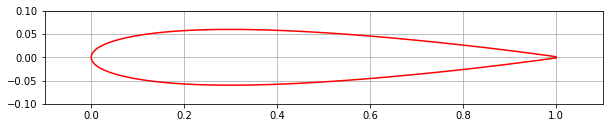

In [2]:
x,y=numpy.loadtxt('naca0012.dat', unpack= True )
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.plot(x,y, color = 'r')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1,1.1)
pyplot.ylim(-0.1,0.1)


In [3]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)
        
        if xb - xa <= 0.0:
            self.beta = math.acos((yb - ya)/self.length)
        else:
            self.beta = math.pi + math.acos(-(yb - ya)/self.length)
            
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
            
        self.sigma = 0.0
        self.vt = 0.0
        self.cp = 0.0

In [4]:
def air_panel(x,y, N_panel):
    R = (x.max() - x.min())/2
    x_center = (x.max() + x.min())/2
    x_circle = x_center + R * numpy.cos(numpy.linspace(0,2*math.pi, N_panel+1))
    
    x_ends = numpy.copy(x_circle)
    y_ends = numpy.zeros_like(x_ends)
    
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])
    
    I=0
    for i in range(N_panel):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    panels = numpy.empty(N_panel, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

(40,)

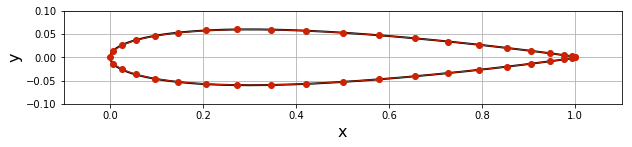

In [5]:
N = 40
panels = air_panel(x,y, N)

width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);
panels.shape

In [23]:
class Freestream:
    
    def __init__(self, u_inf, alpha):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)
    
u_inf = 1.0                            # freestream spee
alpha = 4.0                            # angle of attack (in degrees)
freestream = Freestream(u_inf, alpha)    

In [24]:
def integral(x,y, panel, dxdz, dydz):
    
    def integrand(s):
        a = x - (panel.xa - numpy.sin(panel.beta)*s)
        b = y - (panel.ya + numpy.cos(panel.beta)*s)
        return (a * dxdz + b * dydz) / (a**2+b**2)    
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [25]:
def build_system(panels):
    N = len(panels)
    A = numpy.empty((N,N), dtype = float)
    numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate (panels):
        for j, p_j in enumerate(panels):
            if i!=j:
                A[i,j] = 0.5 / math.pi * integral(p_i.xc, p_i.yc, p_j, numpy.cos(p_i.beta), numpy.sin(p_i.beta))
                
    return A

def build_rhs(panels, freestream):
    b = numpy.empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * math.cos(freestream.alpha - panel.beta)
        
    return b

In [26]:
A = build_system(panels)
b = build_rhs(panels, freestream) 

In [27]:
sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]
sigma

array([-3.5364925 , -2.66451086, -2.1898607 , -1.80233666, -1.52560537,
       -1.32425527, -1.17147069, -1.05068397, -0.95086706, -0.86564446,
       -0.78906999, -0.71686341, -0.64371569, -0.56895796, -0.48716652,
       -0.39248778, -0.26653226, -0.08419023,  0.26509414,  1.02797704,
        1.50357462,  1.15616577,  0.91112493,  0.77676684,  0.69227651,
        0.64289492,  0.61507496,  0.60628502,  0.61437788,  0.64149279,
        0.68539467,  0.74691947,  0.82814008,  0.93518778,  1.07665884,
        1.26904363,  1.53942897,  1.92553548,  2.41259045,  2.8683466 ])

In [28]:
def tangential_velocity(panels, freestream):
    
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / math.pi * integral(p_i.xc, p_i.yc, p_j,
                                                   -math.sin(p_i.beta),
                                                   math.cos(p_i.beta))
    
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    sigma = numpy.array([panel.sigma for panel in panels])
    
    vt = numpy.dot(A, sigma) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]
sigma

array([-3.5364925 , -2.66451086, -2.1898607 , -1.80233666, -1.52560537,
       -1.32425527, -1.17147069, -1.05068397, -0.95086706, -0.86564446,
       -0.78906999, -0.71686341, -0.64371569, -0.56895796, -0.48716652,
       -0.39248778, -0.26653226, -0.08419023,  0.26509414,  1.02797704,
        1.50357462,  1.15616577,  0.91112493,  0.77676684,  0.69227651,
        0.64289492,  0.61507496,  0.60628502,  0.61437788,  0.64149279,
        0.68539467,  0.74691947,  0.82814008,  0.93518778,  1.07665884,
        1.26904363,  1.53942897,  1.92553548,  2.41259045,  2.8683466 ])

In [29]:
tangential_velocity(panels, freestream)

In [30]:
def pressure_coefficient(panels, freestream):
    for panel in panels:
        
        panel.cp = 1 - (panel.vt/ freestream.u_inf)**2

In [31]:
pressure_coefficient(panels, freestream)

In [32]:
voverVsquared=numpy.array([0.0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411,
                           1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044,
                           0.956, 0.906, 0.0])
print(voverVsquared)

xtheo=numpy.array([0.0, 0.5, 1.25, 2.5, 5.0, 7.5, 10.0, 15.0, 20.0, 25.0, 30.0,
                   40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 95.0, 100.0])
xtheo /= 100
print(xtheo)

[0.    0.64  1.01  1.241 1.378 1.402 1.411 1.411 1.399 1.378 1.35  1.288
 1.228 1.166 1.109 1.044 0.956 0.906 0.   ]
[0.     0.005  0.0125 0.025  0.05   0.075  0.1    0.15   0.2    0.25
 0.3    0.4    0.5    0.6    0.7    0.8    0.9    0.95   1.    ]


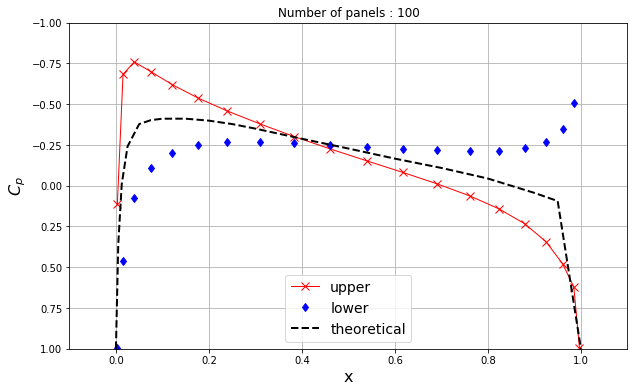

In [34]:
# plot the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper',
            color='r', linewidth=1, marker='x', markersize=8)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label='lower',
            color='b', linewidth=0, marker='d', markersize=6)
pyplot.plot(xtheo, 1-voverVsquared,
            label='theoretical',
            color='k', linestyle='--',linewidth=2)
pyplot.legend(loc='best', prop={'size':14})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -1.0)
pyplot.title('Number of panels : {}'.format(N));

In [35]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels])
print('--> sum of source/sink strengths: {}'.format(accuracy))

--> sum of source/sink strengths: 0.004605784319391609


In [36]:
#velocity field

N = 100                               
x_start, x_end = -1.0, 2.0          
y_start, y_end = -0.3, 0.3            
x = numpy.linspace(x_start, x_end, N)   
y = numpy.linspace(y_start, y_end, N)    
X, Y = numpy.meshgrid(x, y)

ux = numpy.zeros((N,N), dtype=float)
uy = numpy.zeros((N,N), dtype=float)
N_panels=40
for i in range(len(x)):
    for j in range(len(y)):
        b=0.0
        for p in range(N_panels):
            b = b + 0.5*sigma[p]/math.pi * integral(x[i],y[j], panels[p],1, 0)
            ux[j,i] = b
            
for i in range(len(x)):
    for j in range(len(y)):
        b=0.0
        for p in range(N_panels):
            b = b + 0.5*sigma[p]/math.pi * integral(x[i],y[j], panels[p],0, 1) 
            uy[j,i] = b
                
                
u = freestream.u_inf*numpy.cos(freestream.alpha)*numpy.ones((N,N), dtype=float) + ux
v = freestream.u_inf*numpy.sin(freestream.alpha)*numpy.ones((N,N), dtype=float) + uy    
panels[3]

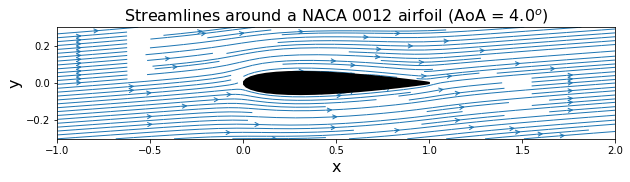

In [37]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=1, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around a NACA 0012 airfoil (AoA = ${}^o$)'.format(alpha),
             fontsize=16);


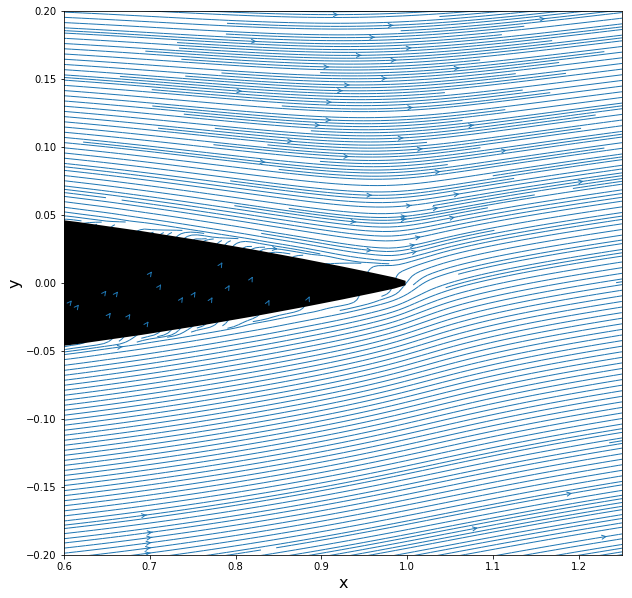

In [43]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(0.6, 1.25)
pyplot.ylim(-0.2, 0.2)
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.streamplot(X, Y, u, v,
                  density=10, linewidth=1, arrowsize=1, arrowstyle='->')